# Visualize Trained Agents

In [1]:
from gymnasium.experimental.wrappers import RecordVideoV0
from orbax.checkpoint import PyTreeCheckpointer

import _pickle as pickle
import jax
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

from jaxl.buffers import get_buffer
from jaxl.constants import *
from jaxl.models import (
    get_model,
    get_policy,
    policy_output_dim,
)
from jaxl.models.policies import MultitaskPolicy
from jaxl.envs import get_environment
from jaxl.envs.rollouts import EvaluationRollout
from jaxl.utils import set_seed, parse_dict, set_dict_value, get_dict_value

In [2]:
run_seed = None
set_seed(run_seed)

In [3]:
def get_env(agent_path):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
    return agent_config_dict["learner_config"]["env_config"]

In [4]:
# Gravity = -8.249612491943623
# agent_path = "/mnt/HDD/research/mtil/inverted_double_pendulum/expert_models/gravity/runs/0/gravity_-8.249612491943623/06-09-23_15_21_56-296b3f54-5c33-43f3-97dd-3b7eb184bc99"
agent_path = "/Users/chanb/research/personal/jaxl/data/inverted_double_pendulum/expert_models/gravity/runs/0/gravity_-8.249612491943623/06-09-23_15_21_56-296b3f54-5c33-43f3-97dd-3b7eb184bc99"

# Gravity = -0.1
# agent_path = "/Users/chanb/research/personal/jaxl/data/inverted_double_pendulum/expert_models/gravity/runs/0/gravity_-0.1/06-20-23_17_58_19-e1219127-8e43-4dd8-a05c-64e71ae09489"
trained_env_parameters = get_env(agent_path)

# Gravity = -8.249612491943623
# agent_path = "/Users/chanb/research/personal/jaxl/data/inverted_double_pendulum/expert_models/gravity/runs/0/gravity_-8.249612491943623/06-09-23_15_21_56-296b3f54-5c33-43f3-97dd-3b7eb184bc99"
# agent_path = "/Users/chanb/research/personal/jaxl/data/inverted_double_pendulum/test_mtbc/gravity-num_tasks_analysis/runs/0/num_tasks_32/06-13-23_20_40_42-1ef9b350-bd18-4fba-b1ad-6e5cbb3dd1ab"
# agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/bc/06-20-23_16_10_06-d21f35f1-8568-46de-8bcc-64a53c1747cd"
# agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/test_mtbc/06-20-23_18_22_22-1b5ce9fd-4d72-40f6-80ff-c9c67aed08ee"
agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/bc-gravity_-8.249612491943623/07-05-23_08_43_57-a8ef0a01-7f01-4192-8b33-a61670eb113c"

# Gravity = -0.1
# agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/test_mtbc-gravity_-0.1/06-21-23_09_41_09-d11d4ba1-1242-47af-addd-c7db5eacb69b"
# agent_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/inverted_double_pendulum/bc-gravity_-0.1/06-21-23_09_41_54-041a7fce-7123-4037-9a87-c99a8f620e65"

num_episodes = 100
env_seed = 9999
buffer_size = 0
record_video = False
gravity = trained_env_parameters["env_kwargs"]["gravity"]

In [5]:
def get_config(agent_path, gravity):
    agent_config_path = os.path.join(agent_path, "config.json")
    with open(agent_config_path, "r") as f:
        agent_config_dict = json.load(f)
        agent_config_dict["learner_config"]["env_config"] = trained_env_parameters
        agent_config_dict["learner_config"]["env_config"]["env_kwargs"][
            "render_mode"
        ] = "rgb_array"
        agent_config_dict["learner_config"]["env_config"]["env_kwargs"][
            "gravity"
        ] = gravity
        if "policy_distribution" not in agent_config_dict["learner_config"]:
            agent_config_dict["learner_config"][
                "policy_distribution"
            ] = CONST_DETERMINISTIC
        set_dict_value(agent_config_dict, "vmap_all", False)
        (multitask, num_models) = get_dict_value(agent_config_dict, "num_models")
        agent_config = parse_dict(agent_config_dict)
    return agent_config, {
        "multitask": multitask,
        "num_models": num_models,
    }

In [6]:
episodic_returns_per_variant = {}
checkpoint_paths = os.listdir(os.path.join(agent_path, "models"))

for checkpoint_path in checkpoint_paths:
    agent_config, aux = get_config(agent_path, gravity)
    env = get_environment(agent_config.learner_config.env_config)

    model_id = int(checkpoint_path.split("-")[-1])
    if record_video:
        env = RecordVideoV0(env, f"model_id_{model_id}-videos")

    input_dim = env.observation_space.shape
    output_dim = policy_output_dim(env.action_space.shape, agent_config.learner_config)
    model = get_model(
        input_dim,
        output_dim,
        getattr(agent_config.model_config, "policy", agent_config.model_config),
    )
    policy = get_policy(model, buffer.output_dim, agent_config.learner_config)
    if aux["multitask"]:
        policy = MultitaskPolicy(policy, model, aux["num_models"])

    agent_model_path = os.path.join(agent_path, "models", checkpoint_path)
    checkpointer = PyTreeCheckpointer()
    model_dict = checkpointer.restore(agent_model_path)
    agent_policy_params = model_dict[CONST_MODEL][CONST_POLICY]
    with open(os.path.join(agent_model_path, "learner_dict.pkl"), "rb") as f:
        learner_dict = pickle.load(f)
        agent_obs_rms = learner_dict[CONST_OBS_RMS]

    agent_rollout = EvaluationRollout(env, seed=env_seed)
    agent_rollout.rollout(
        agent_policy_params, policy, agent_obs_rms, num_episodes, None
    )

    episodic_returns_per_variant[model_id] = agent_rollout.episodic_returns

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_50377/1851525045.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


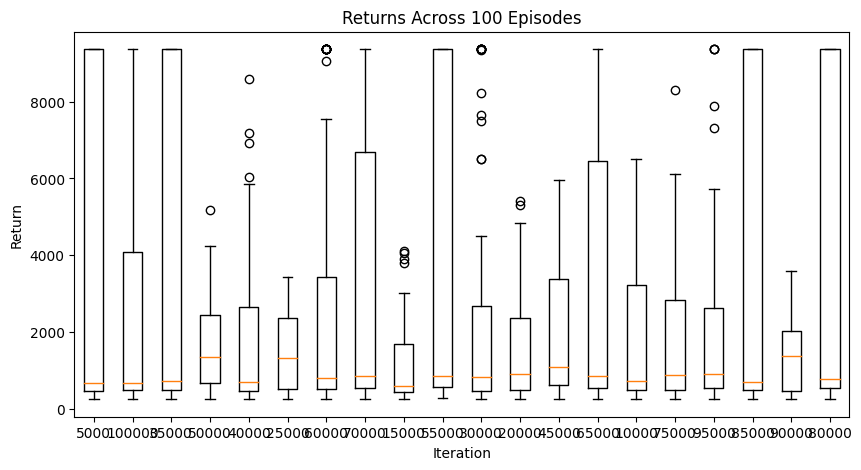

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.boxplot(episodic_returns_per_variant.values())
ax.set_xticks(
    range(1, len(episodic_returns_per_variant) + 1),
    [val if val else "default" for val in episodic_returns_per_variant.keys()],
)
ax.set_title(f"Returns Across {num_episodes} Episodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Return")
fig.show()

In [8]:
from pprint import pprint

pprint(
    [
        (key, np.mean(val), np.std(val))
        for key, val in episodic_returns_per_variant.items()
    ]
)

[(5000, 3357.4030480957617, 4039.347970144007),
 (100000, 2327.224251439738, 2865.1293227856613),
 (35000, 3190.0126317298186, 3830.724275444316),
 (50000, 1587.5657577613667, 1063.4789952432927),
 (40000, 1770.24367959139, 1938.3188947659426),
 (25000, 1423.7349197131905, 914.0442002277501),
 (60000, 2490.82569255006, 3067.5423720625954),
 (70000, 3156.610197399292, 3671.4565673118304),
 (15000, 1093.9506153202417, 961.0361659188551),
 (55000, 3520.9424076747005, 3937.2928385143946),
 (30000, 2214.136537642362, 2692.4857652847454),
 (20000, 1433.9086582877549, 1214.3043819685258),
 (45000, 1868.7175096466456, 1585.5425555572667),
 (65000, 3151.8553220777867, 3682.2071252003675),
 (10000, 1761.1251529349145, 1785.8576249101673),
 (75000, 1798.5470334968518, 1693.8345796741878),
 (95000, 1972.172017877544, 2159.2359577175057),
 (85000, 3234.726670446803, 3982.672217624438),
 (90000, 1413.449152764404, 940.2229108754979),
 (80000, 3227.7446364408343, 3784.2767627297717)]


/var/folders/h6/qs8bwp4d7bg67j4vbv960hdh0000gn/T/ipykernel_50377/3652737342.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


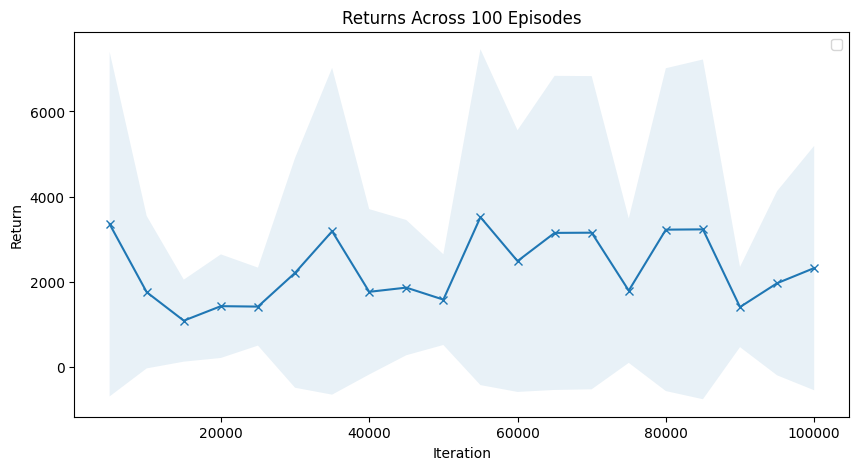

In [9]:
fig, ax = plt.subplots(1, figsize=(10, 5))

model_ids = list(episodic_returns_per_variant.keys())
means = []
stds = []
for val in episodic_returns_per_variant.values():
    means.append(np.mean(val))
    stds.append(np.std(val))
means = np.array(means)
stds = np.array(stds)

sort_idxes = np.argsort(model_ids)
model_ids = np.array(model_ids)
ax.plot(model_ids[sort_idxes], means[sort_idxes], marker="x")
ax.fill_between(
    model_ids[sort_idxes],
    means[sort_idxes] + stds[sort_idxes],
    means[sort_idxes] - stds[sort_idxes],
    alpha=0.1,
)
ax.set_title(f"Returns Across {num_episodes} Episodes")
ax.set_xlabel("Iteration")
ax.set_ylabel("Return")
ax.legend()
fig.show()

In [10]:
print(model_ids[sort_idxes])
print(means[sort_idxes])

[  5000  10000  15000  20000  25000  30000  35000  40000  45000  50000
  55000  60000  65000  70000  75000  80000  85000  90000  95000 100000]
[3357.4030481  1761.12515293 1093.95061532 1433.90865829 1423.73491971
 2214.13653764 3190.01263173 1770.24367959 1868.71750965 1587.56575776
 3520.94240767 2490.82569255 3151.85532208 3156.6101974  1798.5470335
 3227.74463644 3234.72667045 1413.44915276 1972.17201788 2327.22425144]


### Gravity = -0.1
#### PPO
```
[-3.00e+01 -1.50e+01 -1.30e+01 -9.81e+00 -5.00e+00 -1.00e+00 -1.00e-01
 -1.00e-02]
[  90.67406679  164.65052897  192.39404472  238.24816655  364.15402817
 1073.90771963 3504.90991557 4115.21913926]
```

#### MTBC
```
[-3.00e+01 -1.50e+01 -1.30e+01 -9.81e+00 -5.00e+00 -1.00e+00 -1.00e-01
 -1.00e-02]
[  84.5687924   168.33623149  185.48593724  242.48130892  361.57098085
 1016.78342278 3336.88995492 4130.62514417]
```

#### BC
```
[-3.00e+01 -1.50e+01 -1.30e+01 -9.81e+00 -5.00e+00 -1.00e+00 -1.00e-01
 -1.00e-02]
[  88.3836091   173.41462282  190.96280719  234.48176652  354.85274471
  956.50828755 3364.56354645 4215.37381229]
```